# Machine Learning approach
If you are dealing with tabular data (which is a category time series belong to), tree-based methods are something of a Swiss-Army chainsaw: they work out of the box, with minimal requirements on data. In this section we will formulate a time series problem as a regression one, so that we can use LightGBM to predict the sales in multiple stores (we continue working with the data from the M5 competition). Quick reminder of what our data looks like:

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
from data_sources import *
import gc

In [14]:
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)

# general settings
class CFG:
    data_folder = data
    img_dim1 = 20
    img_dim2 = 10

# adjust the parameters for displayed figures
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

In [15]:
def my_rmse(x, y):
    """

    :param x:
    :param y:
    :return:
    """
    return np.round(np.sqrt(mse(x, y)), 4)

In [16]:
xdat = pd.read_csv('data/m5_forecasting_accuracy/sales_train_validation.csv')
xdat = xdat.loc[xdat.state_id == 'CA']
xdat.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


## preprocess data

In [17]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


xdat = reduce_mem_usage(xdat)

Memory usage of dataframe is 178.65 MB
Memory usage after optimization is: 35.74 MB
Decreased by 80.0%


In [18]:
# melt the data into long format
xdat = pd.melt(xdat, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()

# get proper timestamps
xcal = pd.read_csv('data/m5_forecasting_accuracy/calendar.csv')
xcal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [19]:
xdat = pd.merge(xdat, xcal, on='d', how='left')
del xcal

In [20]:
xdat.drop(['d', 'wm_yr_wk', 'weekday', 'month', 'year',  'event_name_1', 'event_type_1',
           'event_name_2', 'event_type_2', 'snap_TX', 'snap_WI', 'state_id'],
                  axis=1, inplace=True)
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


<AxesSubplot:xlabel='date'>

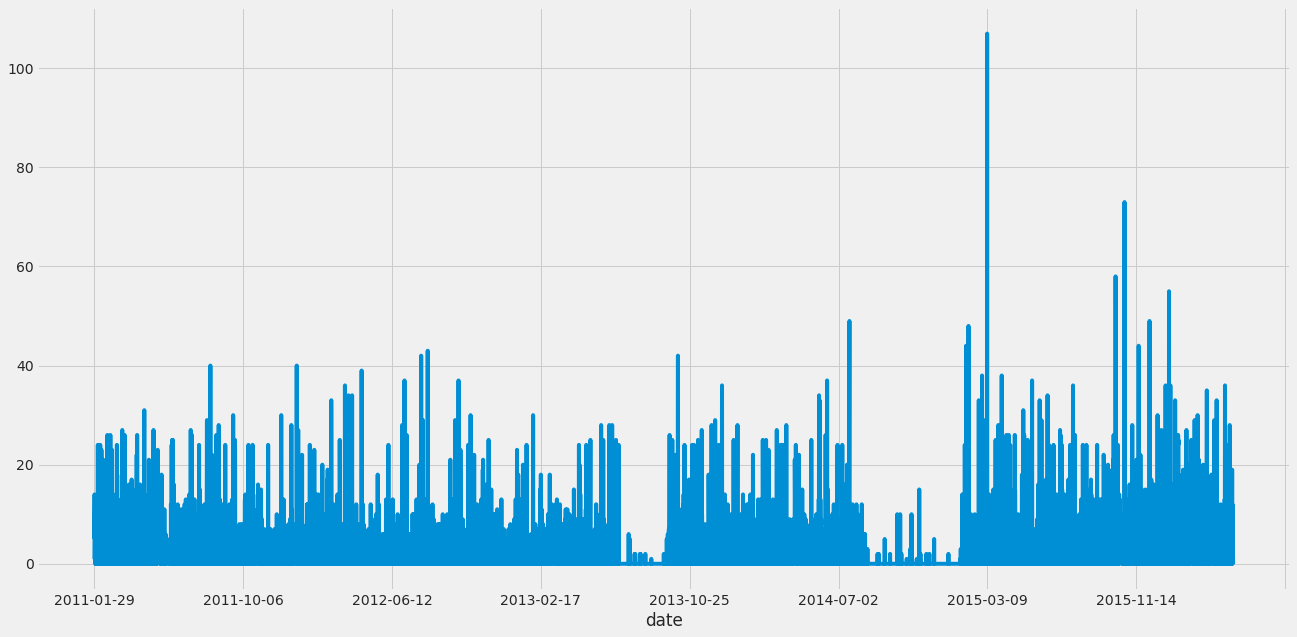

In [21]:
df = xdat.loc[xdat.item_id == 'HOBBIES_1_288' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

<AxesSubplot:xlabel='date'>

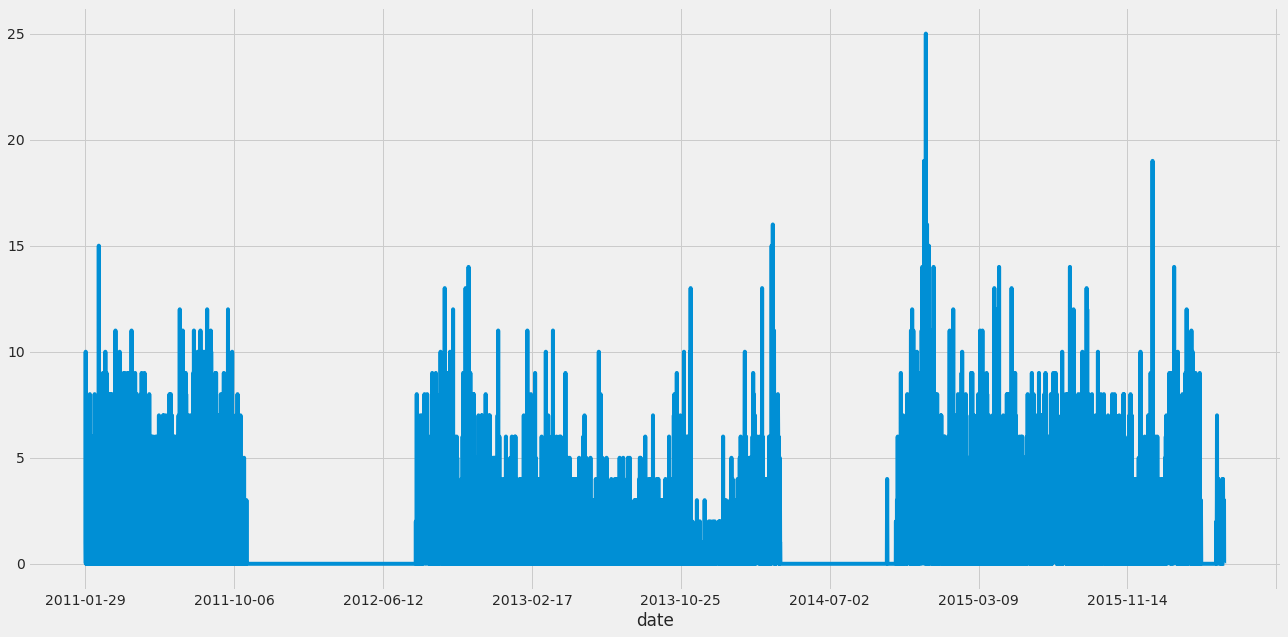

In [22]:
df = xdat.loc[xdat.item_id == 'FOODS_3_823' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

<AxesSubplot:xlabel='date'>

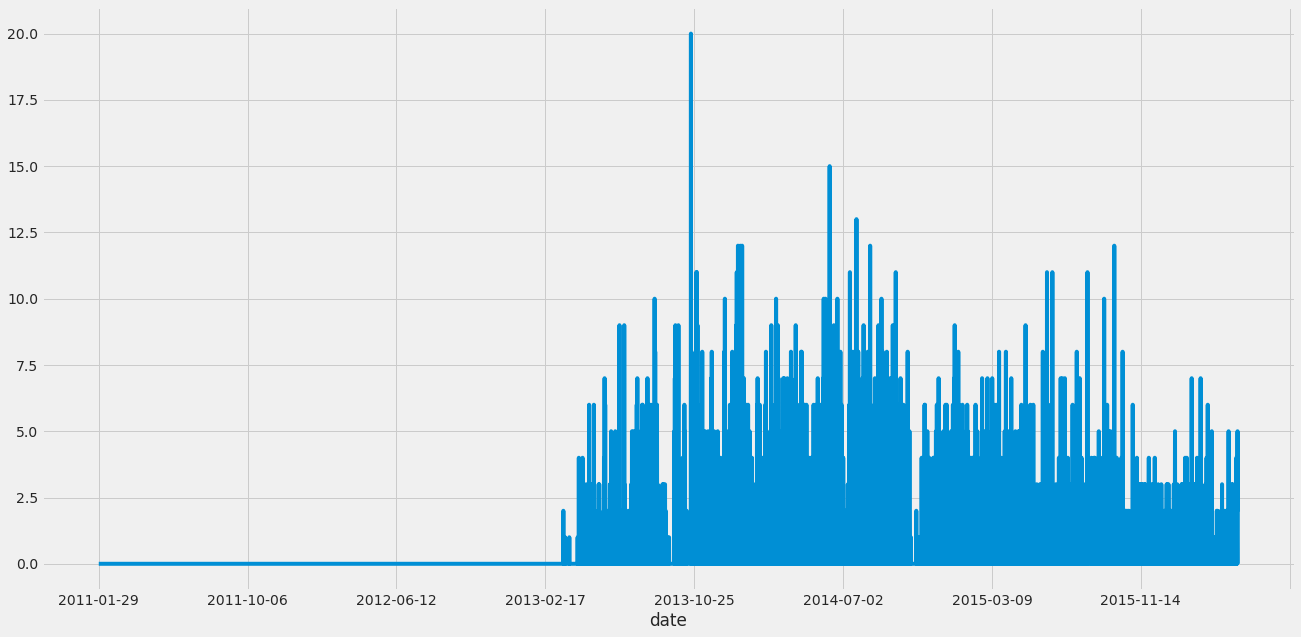

In [23]:
df = xdat.loc[xdat.item_id == 'HOUSEHOLD_2_513' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

We could run multiple separate models like Croston, but it's infeasible for two reasons:
- there are a LOT of store x product combinations
- shared factors between stores

Instead, we will generate some features to capture the temporal dynamics and treat the problem of predicting all the series jointly as a regression.

## feature engineering

In [24]:
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


Start with lag features:
- simple moving averages over a given period
- shifted

In [25]:
def create_features(dt, lags = [28], wins = [7,28]):
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag).fillna(-1)

    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).fillna(-1)
    return dt

xdat = create_features(xdat)
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA,lag_28,rmean_28_7,rmean_28_28
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0,-1.0,-1.0,-1.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0,-1.0,-1.0,-1.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0,-1.0,-1.0,-1.0


Time-based features:

In [26]:
# date features
xdat['date'] = pd.to_datetime(xdat["date"])
date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

for date_feat_name, date_feat_func in date_features.items():
    if date_feat_name in xdat.columns:
        xdat[date_feat_name] = xdat[date_feat_name].astype("int16")
    else:
        xdat[date_feat_name] = getattr(xdat["date"].dt, date_feat_func).astype("int16")

## LightGBM
We are finally ready to go down the usual **lgbm** path:

In [27]:
# encode categorical features
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id']
for cc in cat_feats:
    le = LabelEncoder()
    xdat[cc] = le.fit_transform(xdat[cc])

Can we exploit the nature of the data?

In [28]:
# split into train and test
cutoff = xdat.date.max() - pd.to_timedelta(28, unit = 'D')
xtrain = xdat.loc[xdat.date < cutoff].copy()
xvalid = xdat.loc[xdat.date >= cutoff].copy()
del xdat
xtrain.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA,lag_28,rmean_28_7,rmean_28_28,week,month,quarter,year,mday
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,2011-01-29,1,0,-1.0,-1.0,-1.0,4,1,1,2011,29
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,2011-01-29,1,0,-1.0,-1.0,-1.0,4,1,1,2011,29
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,2011-01-29,1,0,-1.0,-1.0,-1.0,4,1,1,2011,29


In [29]:
ytrain = xtrain['sales'].copy()
yvalid = xvalid['sales'].copy()
xtrain.drop(['id', 'wday', 'sales',  'snap_CA', 'year', 'date'], axis=1, inplace=True)
xvalid.drop(['id', 'wday', 'sales',  'snap_CA', 'year', 'date'], axis=1, inplace=True)

In [30]:
dtrain = lgb.Dataset(xtrain , label=ytrain, free_raw_data=False)
dvalid = lgb.Dataset(xvalid, label=yvalid, free_raw_data=False)

<AxesSubplot:ylabel='Density'>

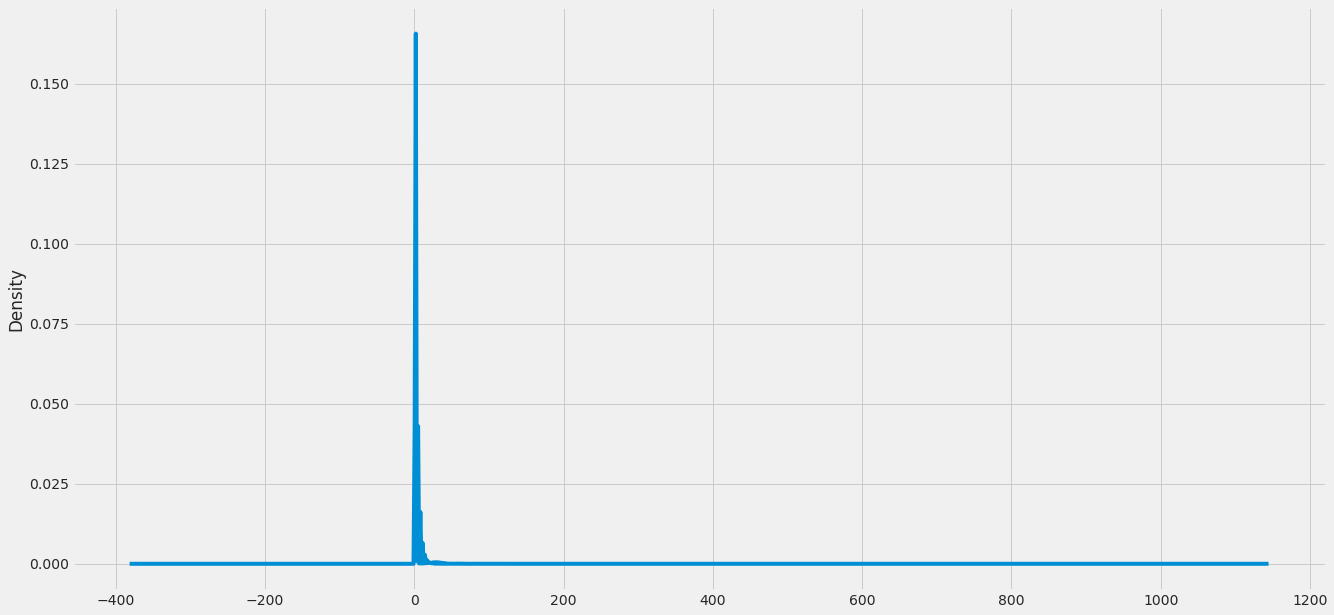

In [31]:
ytrain.plot.density()

Giant spike at zero $\implies$ we need a criterion that allows for a probability mass

In [32]:
params = {
        "objective": "poisson",  # poisson distribution
        "metric": "rmse",
        "learning_rate": 0.075,
         "sub_feature": 0.8,
        "sub_row": 0.75,
        "bagging_freq": 1,
        "lambda_l2": 0.1,
        'verbosity': 1,
       'num_iterations': 1000,
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}

m_lgb = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dvalid],
                  early_stopping_rounds=150,
                  verbose_eval=100)

/home/noone/anaconda3/envs/time_series/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/noone/anaconda3/envs/time_series/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/noone/anaconda3/envs/time_series/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Ligh

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 22977264, number of used features: 11
[LightGBM] [Info] Start training from score 0.203045
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 2.66383	valid_1's rmse: 2.33185
[200]	training's rmse: 2.61925	valid_1's rmse: 2.3214
[300]	training's rmse: 2.57912	valid_1's rmse: 2.31679
[400]	training's rmse: 2.55221	valid_1's rmse: 2.31651
[500]	training's rmse: 2.53173	valid_1's rmse: 2.31832
Early stopping, best iteration is:
[363]	training's rmse: 2.56246	valid_1's rmse: 2.31553


More general step: tweedie https://en.wikipedia.org/wiki/Tweedie_distribution

In [33]:
params = {
        "objective": "tweedie",  # tweedie distribution
        "metric": "rmse",
        "learning_rate": 0.075,
         "sub_feature": 0.8,
        "sub_row": 0.75,
        "bagging_freq": 1,
        "lambda_l2": 0.1,
        'verbosity': 1,
       'num_iterations': 1000,
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}

m_lgb = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dvalid],
                  early_stopping_rounds=150,
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 22977264, number of used features: 11
[LightGBM] [Info] Start training from score 0.203045
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 2.67983	valid_1's rmse: 2.30314
[200]	training's rmse: 2.6414	valid_1's rmse: 2.29437
[300]	training's rmse: 2.61341	valid_1's rmse: 2.29108
[400]	training's rmse: 2.5914	valid_1's rmse: 2.29104
Early stopping, best iteration is:
[289]	training's rmse: 2.61873	valid_1's rmse: 2.29018


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

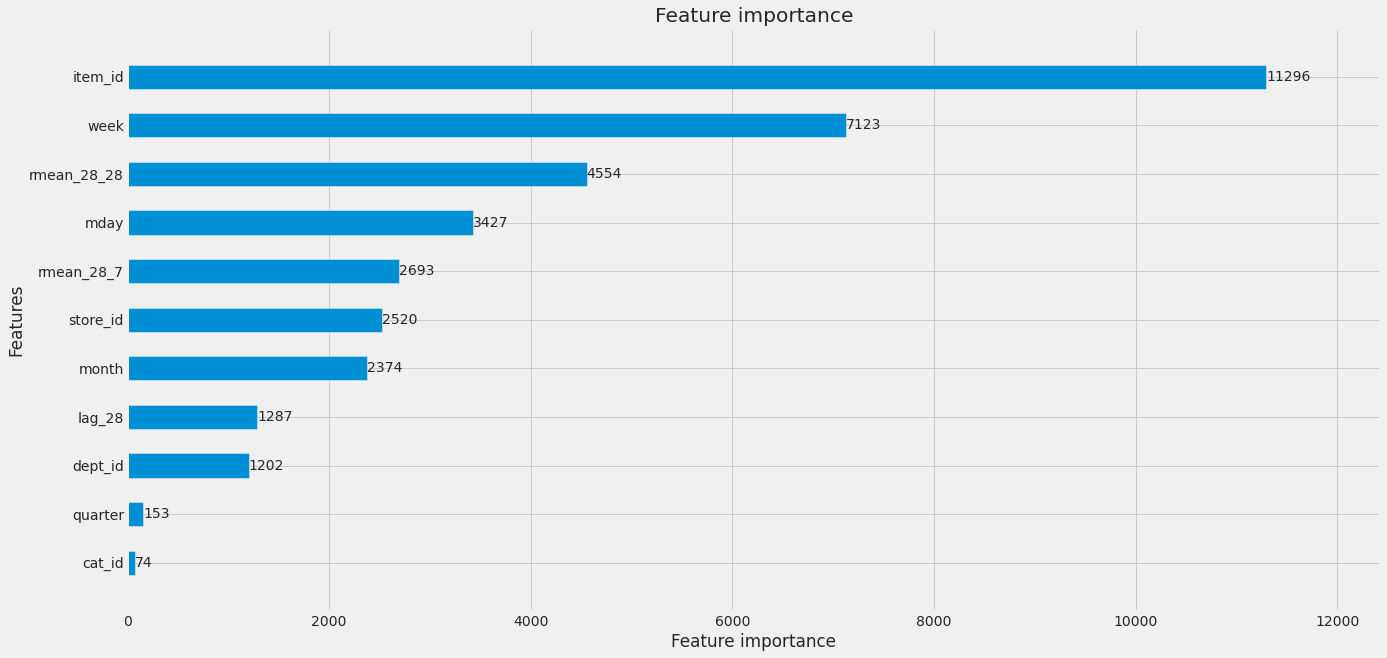

In [34]:
lgb.plot_importance(m_lgb, height=0.5)

In [35]:
gc.collect()

15